<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment1/Assignment_1_MLP_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

Note: We have used the simple wrapper class defined in datasets.py, Please use that wrapper while testing



#Change the directory

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/First_Assignment'
if os.getcwd() !=  working_directory:
  os.chdir(working_directory)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/First_Assignment'

#import statements

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset

##Check tensorflow version

In [4]:
tf.__version__

'2.6.0'

#Load Data

In [5]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
#Re-shape the dataset and then pass it to the function which creates data into batches
def reset_Data():
  return MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

In [7]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Visualize some images on some training and test data

1


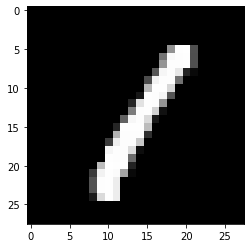

In [8]:
print(train_labels[3])
plt.imshow(train_images[3], cmap="Greys_r")

4


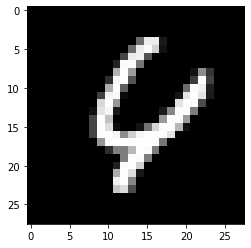

In [9]:
print(test_labels[121])
plt.imshow(test_images[121], cmap="Greys_r")

#A function that will choose the activation function

In [10]:
def dynamicActiFunc(actFun, currLogits):
  if actFun == "relu":
    return tf.nn.relu(currLogits)
  elif actFun == "lrelu":
    return tf.nn.leaky_relu(currLogits)
  elif actFun == "sigmoid":
    return tf.nn.sigmoid(currLogits)
  else:
    return tf.nn.relu(currLogits)

#Define a Generic function for training

In [11]:
def model_Train(_modelConfig, data):
  loss_list = []
  for step in range(_modelConfig["train_steps"]):
      img_batch, lbl_batch = data.next_batch()
      with tf.GradientTape() as tape:
          #loop that will goes forward for every hidden layer
          for ind in range(len(_modelConfig["_weights"])-1):
            if ind == 0:
              hPrevLogits = tf.matmul(img_batch, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
              hPrevOutput = dynamicActiFunc(_modelConfig["activation_func"], hPrevLogits)
            else :
              hcurrLogits = tf.matmul(hPrevOutput, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
              hcurrOutput = dynamicActiFunc(_modelConfig["activation_func"], hcurrLogits)
              hPrevOutput = hcurrOutput

          lastInd = len(_modelConfig["_weights"])-1

          #final output layer
          logits = tf.matmul(hcurrOutput, _modelConfig["_weights"][lastInd]) + _modelConfig["_biases"][lastInd]
          xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
              logits=logits, labels=lbl_batch))
          
      grads = tape.gradient(xent, [*_modelConfig["_weights"], *_modelConfig["_biases"]])

      #update weights
      for ind in range(len(_modelConfig["_weights"])):
        _modelConfig["_weights"][ind].assign_sub(_modelConfig["learning_rate"] * grads[ind])
      
      #update biases
      for ind in range(len(_modelConfig["_biases"])):
        _modelConfig["_biases"][ind].assign_sub(_modelConfig["learning_rate"] * grads[ind + len(_modelConfig["_biases"])])

      loss_list.append(xent)
      if not step % 100:
          print(step)
          preds = tf.argmax(logits, axis=1, output_type=tf.int32)
          acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                              tf.float32))
          print("Loss: {} Accuracy: {}".format(xent, acc))

  #Predict for Test Dataset
  for ind in range(len(_modelConfig["_weights"])-1):
      if ind == 0:
        hPrevLogits = tf.matmul(data.test_data, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
        hPrevOutput = dynamicActiFunc(_modelConfig["activation_func"], hPrevLogits)
      else :
        hcurrLogits = tf.matmul(hPrevOutput, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
        hcurrOutput = dynamicActiFunc(_modelConfig["activation_func"], hcurrLogits)
        hPrevOutput = hcurrOutput

  lastInd = len(_modelConfig["_weights"])-1
  test_preds = tf.argmax(tf.matmul(hcurrOutput, _modelConfig["_weights"][lastInd]) + _modelConfig["_biases"][lastInd], axis=1,
                       output_type=tf.int32)
  acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                              tf.float32))
  print("\nTest Accuracy: {}".format(acc))
  return loss_list

#Models Config

##Relu Activation Function

###Define params Model1

In [12]:
modelConfig1 = {
    "train_steps" : 1000,
    "learning_rate" : 0.1,
    "activation_func" : "relu",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

###Define params Model2

In [13]:
modelConfig2 = {
    "train_steps" : 2000,
    "learning_rate" : 0.01,
    "activation_func" : "relu",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

###Define params Model3

In [14]:
modelConfig3 = {
    "train_steps" : 1000,
    "learning_rate" : 0.1,
    "activation_func" : "relu",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 1568], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([1568, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(1568, dtype=np.float32)),
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

###Define params Model4

In [15]:
modelConfig4 = {
    "train_steps" : 1000,
    "learning_rate" : 0.1,
    "activation_func" : "relu",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 512], minval=-0.15, maxval=0.15, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.15, maxval=0.15, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.15, maxval=0.15, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

##Sigmoid Activation Function

###Define params Model5

In [16]:
modelConfig5 = {
    "train_steps" : 1000,
    "learning_rate" : 0.1,
    "activation_func" : "sigmoid",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

###Define params Model6

In [17]:
modelConfig6 = {
    "train_steps" : 2000,
    "learning_rate" : 0.01,
    "activation_func" : "sigmoid",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

###Define params Model7

In [18]:
modelConfig7 = {
    "train_steps" : 1000,
    "learning_rate" : 0.1,
    "activation_func" : "sigmoid",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 1568], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([1568, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(1568, dtype=np.float32)),
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

###Define params Model8

In [19]:
modelConfig8 = {
    "train_steps" : 1000,
    "learning_rate" : 0.1,
    "activation_func" : "sigmoid",

    "_weights" : [
        tf.Variable(tf.random.uniform([784, 512], minval=-0.15, maxval=0.15, dtype=np.float32)),
        tf.Variable(tf.random.uniform([512, 256], minval=-0.15, maxval=0.15, dtype=np.float32)),
        tf.Variable(tf.random.uniform([256, 10], minval=-0.15, maxval=0.15, dtype=np.float32))
    ],

    "_biases" : [
        tf.Variable(np.zeros(512, dtype=np.float32)),
        tf.Variable(np.zeros(256, dtype=np.float32)),
        tf.Variable(np.zeros(10, dtype=np.float32))
    ]
}

#Models Training

##Relu Models Training

In [20]:
relu_models_Loss = []
print("Model1 Start")
relu_models_Loss.append(model_Train(modelConfig1, reset_Data()))
print("Model1 End")
print("\n")

print("Model2 Start")
relu_models_Loss.append(model_Train(modelConfig2, reset_Data()))
print("Model2 End")
print("\n")

print("Model3 Start")
relu_models_Loss.append(model_Train(modelConfig3, reset_Data()))
print("Model3 End")
print("\n")

print("Model4 Start")
relu_models_Loss.append(model_Train(modelConfig4, reset_Data()))
print("Model4 End")
print("\n")

Model1 Start
0
Loss: 2.4424185752868652 Accuracy: 0.0703125
100
Loss: 0.4265841245651245 Accuracy: 0.8359375
200
Loss: 0.2950618267059326 Accuracy: 0.8984375
300
Loss: 0.24989178776741028 Accuracy: 0.8984375
400
Loss: 0.3571683466434479 Accuracy: 0.921875
Starting new epoch...
500
Loss: 0.3062754273414612 Accuracy: 0.90625
600
Loss: 0.17096789181232452 Accuracy: 0.9609375
700
Loss: 0.22708013653755188 Accuracy: 0.9375
800
Loss: 0.15772274136543274 Accuracy: 0.9453125
900
Loss: 0.19214674830436707 Accuracy: 0.9375
Starting new epoch...

Test Accuracy: 0.9563999772071838
Model1 End


Model2 Start
0
Loss: 2.4327313899993896 Accuracy: 0.0625
100
Loss: 1.6361520290374756 Accuracy: 0.65625
200
Loss: 0.9929279088973999 Accuracy: 0.8515625
300
Loss: 0.7997169494628906 Accuracy: 0.8125
400
Loss: 0.6306605339050293 Accuracy: 0.828125
Starting new epoch...
500
Loss: 0.6130359768867493 Accuracy: 0.8359375
600
Loss: 0.46647554636001587 Accuracy: 0.8828125
700
Loss: 0.5693310499191284 Accuracy: 0.78

##Sigmoid Models Training

In [21]:
sigmoid_models_Loss = []

print("Model5 Start")
sigmoid_models_Loss.append(model_Train(modelConfig5, reset_Data()))
print("Model5 End")
print("\n")

print("Model6 Start")
sigmoid_models_Loss.append(model_Train(modelConfig6, reset_Data()))
print("Model6 End")
print("\n")

print("Model7 Start")
sigmoid_models_Loss.append(model_Train(modelConfig7, reset_Data()))
print("Model7 End")
print("\n")

print("Model8 Start")
sigmoid_models_Loss.append(model_Train(modelConfig8, reset_Data()))
print("Model8 End")
print("\n")

Model5 Start
0
Loss: 2.3299221992492676 Accuracy: 0.125
100
Loss: 2.130507707595825 Accuracy: 0.5859375
200
Loss: 1.799695372581482 Accuracy: 0.65625
300
Loss: 1.2939327955245972 Accuracy: 0.71875
400
Loss: 0.9421064853668213 Accuracy: 0.75
Starting new epoch...
500
Loss: 0.7453756928443909 Accuracy: 0.8125
600
Loss: 0.6239126920700073 Accuracy: 0.875
700
Loss: 0.5947445631027222 Accuracy: 0.8359375
800
Loss: 0.5863546133041382 Accuracy: 0.8203125
900
Loss: 0.6496519446372986 Accuracy: 0.8046875
Starting new epoch...

Test Accuracy: 0.8804000020027161
Model5 End


Model6 Start
0
Loss: 2.332751750946045 Accuracy: 0.1484375
100
Loss: 2.2896533012390137 Accuracy: 0.109375
200
Loss: 2.271111488342285 Accuracy: 0.1796875
300
Loss: 2.2568421363830566 Accuracy: 0.296875
400
Loss: 2.2561235427856445 Accuracy: 0.2890625
Starting new epoch...
500
Loss: 2.224205255508423 Accuracy: 0.3828125
600
Loss: 2.2075767517089844 Accuracy: 0.3984375
700
Loss: 2.1962075233459473 Accuracy: 0.5625
800
Loss: 2.

#visualize the loss

## Relu Loss

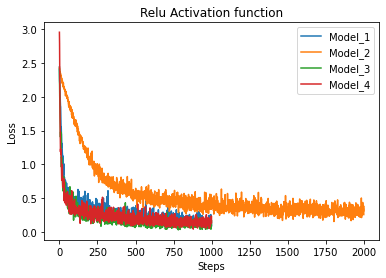

In [22]:
plt.plot(relu_models_Loss[0], label='Model_1')
plt.plot(relu_models_Loss[1], label='Model_2')
plt.plot(relu_models_Loss[2], label='Model_3')
plt.plot(relu_models_Loss[3], label='Model_4')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Relu Activation function')
plt.legend()
plt.show()

## Sigmoid Loss

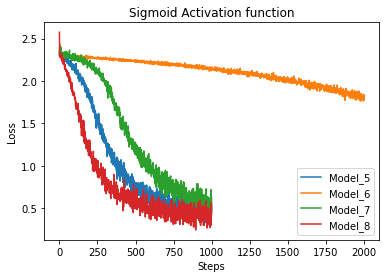

In [23]:
plt.plot(sigmoid_models_Loss[0], label='Model_5')
plt.plot(sigmoid_models_Loss[1], label='Model_6')
plt.plot(sigmoid_models_Loss[2], label='Model_7')
plt.plot(sigmoid_models_Loss[3], label='Model_8')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Sigmoid Activation function')
plt.legend()
plt.show()

#References


1.   http://blog.ai.ovgu.de/posts/jens/2019/002_tf20_basic_mnist/index.html
2.   https://ovgu-ailab.github.io/idl2020w/assignments/1/datasets.py

